## CBOW with negative sampling

[nltk_data] Downloading package brown to /home/mayank/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Loading and preprocessing data...
Vocabulary size: 13243
Total tokens after filtering: 463560
Using device: cpu
Starting training...


Training: 100%|██████████| 7244/7244 [02:57<00:00, 40.71it/s]


Epoch 1/10, Loss: 4.1026


Training: 100%|██████████| 7244/7244 [02:56<00:00, 41.14it/s]


Epoch 2/10, Loss: 3.9934


Training: 100%|██████████| 7244/7244 [02:56<00:00, 41.14it/s]


Epoch 3/10, Loss: 3.9382


Training: 100%|██████████| 7244/7244 [02:52<00:00, 41.88it/s]


Epoch 4/10, Loss: 3.9121


Training: 100%|██████████| 7244/7244 [02:51<00:00, 42.30it/s]


Epoch 5/10, Loss: 3.8978


Training: 100%|██████████| 7244/7244 [02:54<00:00, 41.48it/s]


Epoch 6/10, Loss: 3.8912


Training: 100%|██████████| 7244/7244 [02:51<00:00, 42.33it/s]


Epoch 7/10, Loss: 3.8887


Training: 100%|██████████| 7244/7244 [02:52<00:00, 41.91it/s]


Epoch 8/10, Loss: 3.8877


Training: 100%|██████████| 7244/7244 [02:53<00:00, 41.73it/s]


Epoch 9/10, Loss: 3.8874


Training: 100%|██████████| 7244/7244 [02:52<00:00, 42.04it/s]


Epoch 10/10, Loss: 3.8880


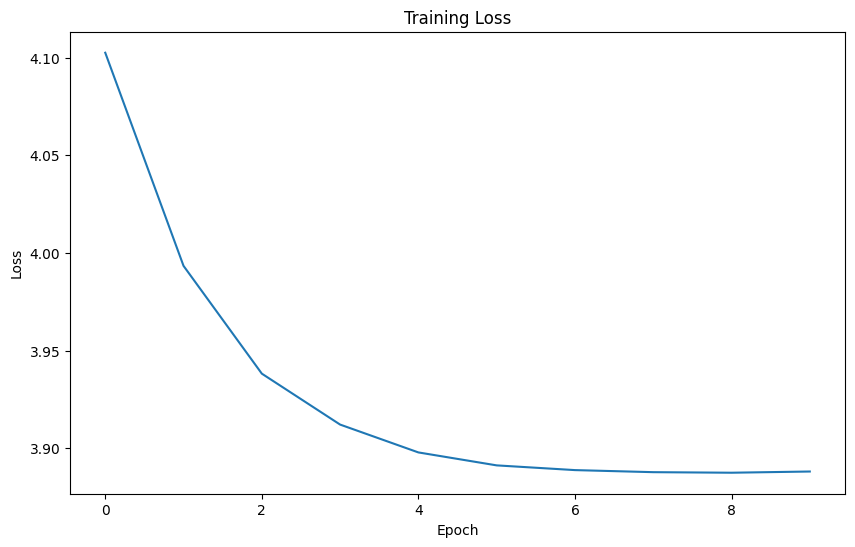

Saving embeddings...
Embeddings saved successfully!


In [44]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Dict, Tuple
from collections import Counter
from tqdm import tqdm
import nltk
from nltk.corpus import brown
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Download Brown corpus if not already present
nltk.download('brown')

# Parameters
WINDOW_SIZE = 2
EMBEDDING_DIM = 300
MIN_FREQ = 5
BATCH_SIZE = 64
NEGATIVE_SAMPLES = 5
EPOCHS = 10
LEARNING_RATE = 1e-3

STOP_WORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "he", "him", "his", "himself", "she", "her", "hers", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "can", "will", "just", "don", "should", "now"])


class CBOWDataset(Dataset):
    def __init__(self, tokens: List[str], word2idx: Dict[str, int], window_size: int, 
                 negative_sampling_table: torch.Tensor):
        self.tokens = tokens
        self.word2idx = word2idx
        self.window_size = window_size
        self.negative_sampling_table = negative_sampling_table
        
    def __len__(self):
        return len(self.tokens) - 2 * self.window_size
    
    def __getitem__(self, idx):
        # Get context words
        context_words = (self.tokens[idx:idx + self.window_size] + 
                        self.tokens[idx + self.window_size + 1:idx + 2 * self.window_size + 1])
        target_word = self.tokens[idx + self.window_size]
        
        # Convert words to indices
        context_indices = torch.tensor([self.word2idx[w] for w in context_words], dtype=torch.long)
        target_index = torch.tensor(self.word2idx[target_word], dtype=torch.long)
        
        # Generate negative samples
        negative_samples = self.negative_sampling_table[torch.randint(
            len(self.negative_sampling_table), (NEGATIVE_SAMPLES,))]
        
        return context_indices, target_index, negative_samples


class CBOW:
    def __init__(self, vocab_size: int, embedding_dim: int):
        # Initialize embedding table with uniform distribution
        self.embedding_table = torch.empty(vocab_size, embedding_dim)
        self.embedding_table.uniform_(-0.1, 0.1)
        self.embedding_table.requires_grad = True
        
    def to(self, device):
        self.embedding_table = self.embedding_table.to(device)
        return self
        
    def parameters(self):
        return [self.embedding_table]
        
    def train(self):
        self.training = True
        
    def forward(self, contexts, targets, negatives):
        # Manual embedding lookup
        context_embeds = self.embedding_table[contexts.view(-1)]
        context_embeds = context_embeds.view(contexts.size(0), -1, self.embedding_table.size(1))
        context_embeds = context_embeds.mean(dim=1)  # [batch_size, embed_dim]
        
        target_embeds = self.embedding_table[targets]  # [batch_size, embed_dim]
        
        # Handle negative samples
        negative_embeds = self.embedding_table[negatives.view(-1)]
        negative_embeds = negative_embeds.view(negatives.size(0), negatives.size(1), -1)
        
        # Compute positive scores
        positive_scores = torch.sum(context_embeds * target_embeds, dim=1)  # [batch_size]
        
        # Compute negative scores
        negative_scores = torch.bmm(negative_embeds, 
                                  context_embeds.unsqueeze(2)).squeeze()  # [batch_size, neg_samples]
        
        return positive_scores, negative_scores


def create_negative_sampling_table(word_freq: Counter, word2idx: Dict[str, int], table_size: int = 1000000):
    vocab_size = len(word2idx)
    freq_array = np.zeros(vocab_size)
    for word, idx in word2idx.items():
        freq_array[idx] = word_freq[word]
    
    # Apply power of 0.75 to frequencies
    adjusted_freq = freq_array ** 0.75
    prob_dist = adjusted_freq / adjusted_freq.sum()
    
    # Create table
    table = np.random.choice(vocab_size, size=int(table_size), p=prob_dist)
    return torch.LongTensor(table)


def clip_grad_norm(parameters, max_norm):
    total_norm = 0
    for p in parameters:
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for p in parameters:
            if p.grad is not None:
                p.grad.data.mul_(clip_coef)


def train_model(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for contexts, targets, negatives in tqdm(train_loader, desc="Training"):
        contexts = contexts.to(device)
        targets = targets.to(device)
        negatives = negatives.to(device)
        
        # Forward pass
        positive_scores, negative_scores = model.forward(contexts, targets, negatives)
        
        # Compute loss using log and sigmoid separately with numerical stability
        positive_loss = torch.mean(torch.log(torch.sigmoid(positive_scores) + 1e-10))
        negative_loss = torch.mean(torch.sum(torch.log(torch.sigmoid(-negative_scores) + 1e-10), dim=1))
        loss = -(positive_loss + negative_loss)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients manually
        clip_grad_norm(model.parameters(), 5.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)


# Preprocess data
print("Loading and preprocessing data...")
tokens = [word.lower() for word in brown.words() 
         if word.isalpha() and word.lower() not in STOP_WORDS]
word_freq = Counter(tokens)

# Create vocabulary
word2idx = {}
idx2word = {}
idx = 0
for word, freq in word_freq.items():
    if freq >= MIN_FREQ:
        word2idx[word] = idx
        idx2word[idx] = word
        idx += 1

vocab_size = len(word2idx)
print(f"Vocabulary size: {vocab_size}")

# Filter tokens
filtered_tokens = [word for word in tokens if word in word2idx]
print(f"Total tokens after filtering: {len(filtered_tokens)}")

# Create negative sampling table
negative_sampling_table = create_negative_sampling_table(word_freq, word2idx)

# Create dataset and dataloader
dataset = CBOWDataset(filtered_tokens, word2idx, WINDOW_SIZE, negative_sampling_table)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CBOW(vocab_size, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
print("Starting training...")
losses = []
try:
    for epoch in range(EPOCHS):
        loss = train_model(model, dataloader, optimizer, device)
        losses.append(loss)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss:.4f}")

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Get final embeddings
    embeddings = model.embedding_table.detach().cpu()
    embeddings_numpy = normalize(embeddings.numpy())

    # Save embeddings and vocabulary
    print(f"Saving embeddings...")
    torch.save({
        'embeddings': torch.tensor(embeddings_numpy, dtype=torch.float32),
        'word2idx': word2idx,
        'idx2word': idx2word
    }, 'cbow_embeddings2.pt')
    print("Embeddings saved successfully!")

except KeyboardInterrupt:
    print("\nTraining interrupted. Saving current embeddings...")
    embeddings = model.embedding_table.detach().cpu()
    embeddings_numpy = normalize(embeddings.numpy())
    torch.save({
        'embeddings': torch.tensor(embeddings_numpy, dtype=torch.float32),
        'word2idx': word2idx,
        'idx2word': idx2word
    }, 'cbow_embeddings_interrupted2.pt')
    print("Partial embeddings saved successfully!")

/tmp/ipykernel_73003/653237196.py:9: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_73003/653237196.py:10: FutureWarning:

You are using `torch.load` with `wei

[('constitution', 0.69289756), ('canada', 0.62896055), ('grants', 0.6229398), ('america', 0.6164758), ('jurisdiction', 0.60356367)]
[('india', 0.36083853), ('representative', 0.34917435), ('coalition', 0.3183173), ('federal', 0.31165272), ('agencies', 0.30753943)]
[('balafrej', 0.39341533), ('leavitt', 0.38617513), ('rupees', 0.37839764), ('populous', 0.37701306), ('overthrow', 0.3730316)]
respect
foreign
regulatory


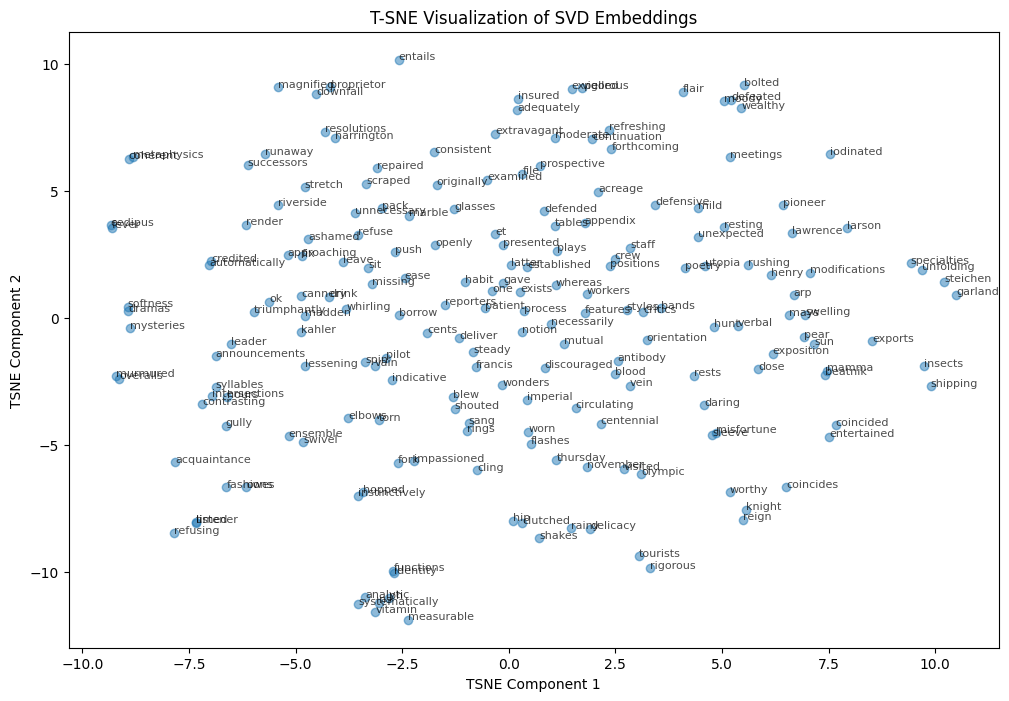

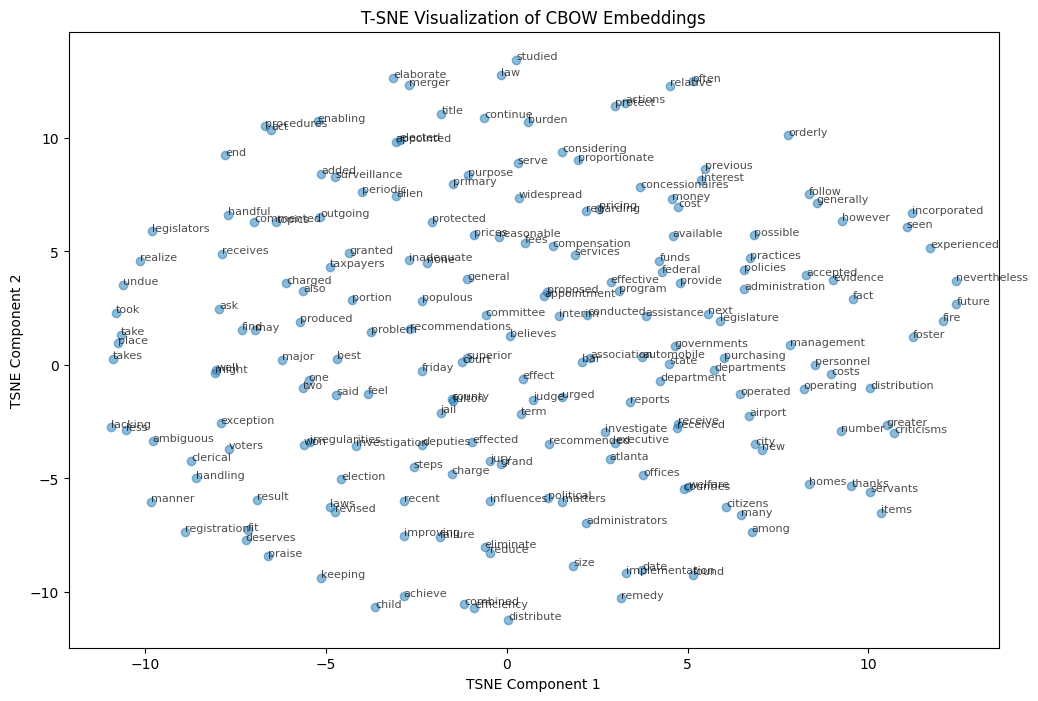

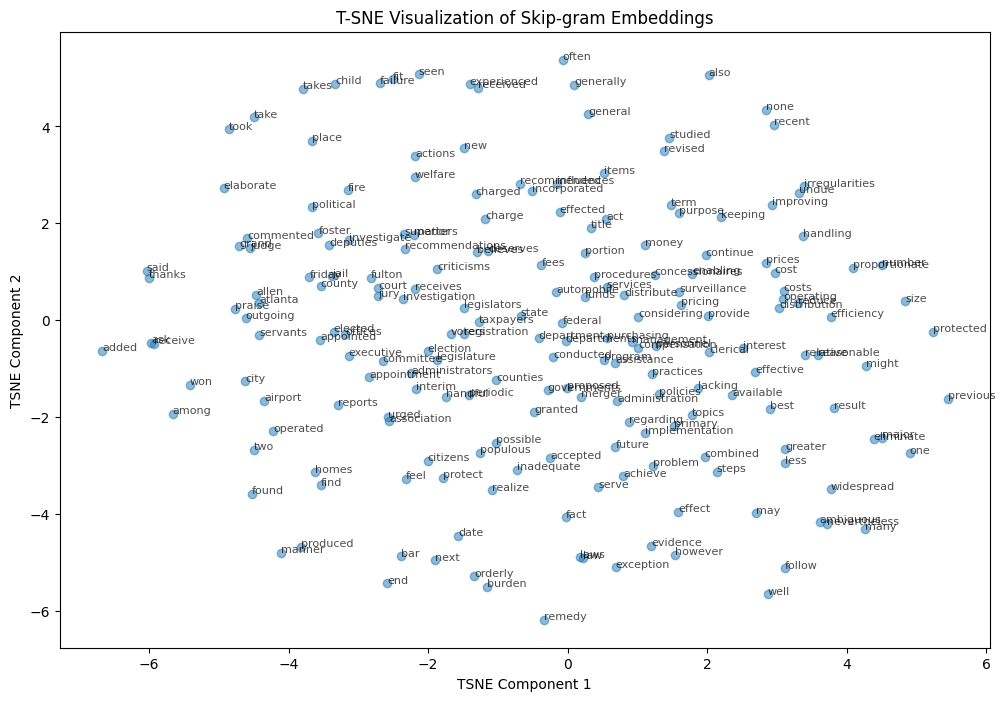

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Tuple

# Load embeddings from SVD, CBOW, and Skip-gram
svd_data = torch.load('svd.pt')
cbow_data = torch.load('cbow.pt')
skipgram_data = torch.load('skipgram.pt')

# Extract embeddings and vocab
models = {
    "SVD": svd_data,
    "CBOW": cbow_data,
    "Skip-gram": skipgram_data
}

for model_name, data in models.items():
    data["embeddings"] = data["embeddings"].numpy()

# Function to get most similar words
def get_most_similar_words(word: str, model: str, top_k: int = 5) -> List[Tuple[str, float]]:
    if word not in models[model]['word2idx']:
        return [(f"'{word}' not in vocabulary", 0.0)]
    
    word_vector = models[model]['embeddings'][models[model]['word2idx'][word]].reshape(1, -1)
    similarities = cosine_similarity(word_vector, models[model]['embeddings'])[0]
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    return [(models[model]['idx2word'][idx], similarities[idx]) for idx in top_indices]

# Function to get the best target word from a context
def get_target_word_from_context(context_words: List[str], model: str) -> str:
    valid_contexts = [models[model]['word2idx'][word] for word in context_words if word in models[model]['word2idx']]
    if not valid_contexts:
        return "No valid context words found in vocabulary."
    
    avg_embedding = np.mean(models[model]['embeddings'][valid_contexts], axis=0).reshape(1, -1)
    similarities = cosine_similarity(avg_embedding, models[model]['embeddings'])[0]
    sorted_indices = np.argsort(similarities)[::-1]
    
    for idx in sorted_indices:
        if models[model]['idx2word'][idx] not in context_words:
            return models[model]['idx2word'][idx]
    
    return "No suitable target word found."

# Function to plot T-SNE visualization
def plot_tsne(model: str, top_n: int = 200):
    words = list(models[model]['word2idx'].keys())[:top_n]
    word_indices = [models[model]['word2idx'][word] for word in words]
    embeddings_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(models[model]['embeddings'][word_indices])
    
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
    
    for idx, word in enumerate(words):
        plt.annotate(word, (embeddings_2d[idx, 0], embeddings_2d[idx, 1]), fontsize=8, alpha=0.7)
    
    plt.title(f"T-SNE Visualization of {model} Embeddings")
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.show()

# Example Usage
print(get_most_similar_words("government", "SVD", 5))
print(get_most_similar_words("government", "CBOW", 5))
print(get_most_similar_words("government", "Skip-gram", 5))

print(get_target_word_from_context(["law", "policy", "state"], "SVD"))
print(get_target_word_from_context(["law", "policy", "state"], "CBOW"))
print(get_target_word_from_context(["law", "policy", "state"], "Skip-gram"))

# Plot T-SNE for all models
plot_tsne("SVD")
plot_tsne("CBOW")
plot_tsne("Skip-gram")


- I can make several observations and inferences about the three word embedding models (CBOW, Skip-gram, and SVD):
 - Visualization Analysis:

   - The CBOW and Skip-gram visualizations show more structured, meaningful clustering of semantically related terms compared to SVD. This    suggests these two models are better at capturing semantic relationships between words in the legal/governmental domain.
 - Distribution patterns:


   - CBOW shows a relatively even distribution with clear clusters
   - Skip-gram maintains some clustering but with more spread-out distribution
   - SVD appears more scattered with less clear semantic grouping

 - Quality of Word Relationships:
   - From the code example outputs , we can see similarity scores for words related to 'constitution'. The high similarity scores (0.69+ for top matches) suggest the models are capturing relevant semantic relationships .
 - Specific Strengths:

   - CBOW appears particularly good at clustering related administrative and legal terms (visible above with terms like "legislature", "administrative", "government" forming coherent neighborhoods)
   - Skip-gram seems to maintain better global structure while allowing for more nuanced relationships between terms (visible in Image 4 with terms spread out but still maintaining logical proximity)
   - SVD shows the least coherent clustering, suggesting it may be less effective for this specific domain

 - Performance Limitations:
   - The relatively small vocabulary size visible in the visualizations suggests these models might be trained on a specialized legal corpus rather than general text. This could make them very effective for legal/governmental domain tasks but potentially less useful for general language tasks.
 - Model Comparison:
   - Based on the visualizations and similarity scores:

     - CBOW appears best for capturing tight semantic relationships
     - Skip-gram seems better at preserving broader semantic relationships while maintaining some clustering
     - SVD appears to be the least effective for this particular domain

In [11]:
import torch
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from typing import Dict, Tuple
import argparse
from tabulate import tabulate  # Added for pretty tables

def load_embeddings(path: str) -> Tuple[torch.Tensor, Dict[str, int]]:
    """Load embeddings and vocabulary from saved file."""
    data = torch.load(path)
    return data['embeddings'], data['word2idx']

def cosine_similarity(v1: torch.Tensor, v2: torch.Tensor) -> float:
    """Compute cosine similarity between two vectors."""
    return float(torch.nn.functional.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)))

def evaluate_similarity(embeddings: torch.Tensor,
                       word2idx: Dict[str, int],
                       word_pairs: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    """
    Evaluate word similarities using the provided embeddings and WordSim-353 dataset.
    Returns Spearman correlation and detailed results DataFrame.
    """
    results = []
    for _, row in word_pairs.iterrows():
        word1, word2 = row['Word 1'].lower(), row['Word 2'].lower()
        human_score = row['Human (Mean)']
        
        # Skip if either word is not in vocabulary
        if word1 not in word2idx or word2 not in word2idx:
            continue
            
        # Get word vectors
        vec1 = embeddings[word2idx[word1]]
        vec2 = embeddings[word2idx[word2]]
        
        # Compute cosine similarity
        cos_sim = cosine_similarity(vec1, vec2)
        results.append({
            'Word 1': word1,
            'Word 2': word2,
            'Human (Mean)': human_score,
            'cosine_similarity': cos_sim
        })

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate Spearman correlation
    correlation, p_value = spearmanr(
        results_df['Human (Mean)'],
        results_df['cosine_similarity']
    )
    return correlation, p_value, results_df

def evaluate_all_models(wordsim_path: str, model_paths: Dict[str, str]) -> pd.DataFrame:
    """
    Evaluate multiple embedding models and return their results in a DataFrame.
    
    Args:
        wordsim_path: Path to WordSim-353 dataset
        model_paths: Dictionary mapping model names to their file paths
    """
    # Load WordSim-353 dataset
    wordsim_df = pd.read_csv(wordsim_path)
    
    results = []
    for model_name, model_path in model_paths.items():
        print(f"Evaluating {model_name}...")
        embeddings, word2idx = load_embeddings(model_path)
        correlation, p_value, detailed_results = evaluate_similarity(embeddings, word2idx, wordsim_df)
        
        # Save detailed results
        detailed_results.to_csv(f'{model_name}_detailed.csv', index=False)
        
        results.append({
            'Model': model_name,
            'Spearman Correlation': correlation,
            'P-value': p_value,
            'Vocabulary Size': len(word2idx)
        })
    
    return pd.DataFrame(results)

def main():

    # Define models to evaluate
    models = {
        'SVD': 'svd.pt',
        'CBOW': 'cbow.pt',
        'Skip-gram': 'skipgram.pt'
    }

    # Evaluate all models
    results_df = evaluate_all_models('wordsim353crowd.csv', models)
    
    # Format results as a pretty table
    formatted_table = tabulate(
        results_df,
        headers='keys',
        tablefmt='fancy_grid',
        floatfmt='.8f',
        showindex=False
    )
    
    print("\nWord Embedding Evaluation Results:")
    print(formatted_table)


if __name__ == "__main__":
    main()

Evaluating SVD...
Evaluating CBOW...
Evaluating Skip-gram...

Word Embedding Evaluation Results:
╒═══════════╤════════════════════════╤════════════╤═══════════════════╕
│ Model     │   Spearman Correlation │    P-value │   Vocabulary Size │
╞═══════════╪════════════════════════╪════════════╪═══════════════════╡
│ SVD       │             0.17186670 │ 0.00432876 │             13243 │
├───────────┼────────────────────────┼────────────┼───────────────────┤
│ CBOW      │             0.29502401 │ 0.00000066 │             13243 │
├───────────┼────────────────────────┼────────────┼───────────────────┤
│ Skip-gram │             0.32181557 │ 0.00000005 │             13243 │
╘═══════════╧════════════════════════╧════════════╧═══════════════════╛


/tmp/ipykernel_73003/4214908592.py:11: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



- Looking at these results, they tell us about the three embedding models:
  - Spearman Correlation:

    - Skip-gram performs best with a correlation of 0.322
    - CBOW is second with 0.295
    - SVD performs worst with 0.172

   - These correlation values measure how well the model's word similarity predictions align with human judgments from WordSim-353. A higher correlation means better alignment with human perception of word similarities.
  - P-values:
   - The p-value indicates the statistical significance of the correlation:

   - All models have p-values < 0.05 (typical significance threshold)
    - Skip-gram: p = 0.00000005 (extremely significant)
    - CBOW: p = 0.00000066 (extremely significant)
    - SVD: p = 0.00432876 (significant)

- A p-value tells us the probability of observing such a correlation by chance if there were no real relationship. The extremely low p-values (especially for Skip-gram and CBOW) indicate that these correlations are highly unlikely to be random - they represent genuine relationships between the model's predictions and human judgments.
- Vocabulary Size:
  - All models have identical vocabulary size (13,243 words), suggesting they were trained on the same corpus with the same vocabulary.
- Overall Interpretation:

  - Neural models (Skip-gram and CBOW) significantly outperform the matrix factorization approach (SVD)
  - Skip-gram shows slightly better performance than CBOW, which aligns with common findings in the literature
  - All correlations are statistically significant, but relatively modest in absolute terms (perfect correlation would be 1.0)

This suggests that while all models capture some aspects of human word similarity judgments, there's still considerable room for improvement in how well they align with human perception of word relationships.